## Klasyfikacja Obrazów Twarzy na Rasy

Przedmiot: Analiza danych multimedialnych

Prowadzący: dr inż. Łukasz Jeleń

Autorzy: Filip Macek 103762, Patryk Mężyk 103893

Nr grupy zajęciowej: SOTS_M_II_NWh_INF_SIiUM_lab 1


### 1. Dane - Dataset

https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset

Wykorzystany Dataset pierwotnie służył do detekcji wieku jednak był to jednocześnie najlepszy jaki nalezlismy pod względem naszej klasyfikacji.

In [1]:

DATASET_PATH = 'dataset_sorted'

### 2. Import bibliotek
Zestaw narzędzi do przetwarzania obrazu (OpenCV, Scikit-image), obliczeń numerycznych (NumPy), wizualizacji (Matplotlib) oraz uczenia maszynowego (Scikit-learn). Importujemy tu również klasyfikatory KNN i MLP (Perceptron) oraz narzędzia do balansowania danych (SMOTE).

In [2]:
### 2. Import bibliotek
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from scipy.spatial import distance
import random

# Analiza obrazu
from skimage.feature import hog, local_binary_pattern # <--- NOWOŚĆ: LBP
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Modele
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier # Potrzebny tylko do selekcji cech!

# Ewaluacja i Selekcja
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import f_classif, SequentialFeatureSelector # <--- NOWOŚĆ: Selekcja

### 3. Stałe i Bank Filtrów Gabora
Definiujemy rozmiar obrazów (128x128). Tworzymy również **Bank Filtrów Gabora**. Filtry te działają podobnie do ludzkiej kory wzrokowej – wykrywają prążki, krawędzie i tekstury pod różnymi kątami i o różnej częstotliwości. Użyjemy ich do ekstrakcji informacji o teksturze skóry i zmarszczkach.

In [3]:
### 3. Stałe i Bank Filtrów Gabora
IMG_SIZE = (128, 128)

def build_gabor_filters():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 4):
        for sigma in (1, 3):
            for lambd in (10, 15):
                gamma = 0.5
                psi = 0
                kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
                kern /= 1.5 * kern.sum()
                filters.append(kern)
    return filters

GABOR_BANK = build_gabor_filters()
print(f"Utworzono bank filtrów Gabora: {len(GABOR_BANK)} filtrów.")

Utworzono bank filtrów Gabora: 16 filtrów.


### 4. Funkcje Przetwarzania Obrazu i Ekstrakcji Cech
Dodaliśmy nową metodę: **LBP (Local Binary Patterns)**.
* `preprocess_image_advanced`: Normalizuje oświetlenie (CLAHE).
* `extract_hog_features`: Kształt/Krawędzie.
* `extract_gabor_features`: Tekstura kierunkowa.
* `extract_lbp_features` (**NOWE**): Tekstura lokalna (mikrowzorce).

In [4]:
### 4. Funkcje Przetwarzania i Ekstrakcji (HOG + Gabor + LBP)
def preprocess_image_advanced(image_path, size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return None
    img = cv2.resize(img, size)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img)
    img_final = cv2.GaussianBlur(img_clahe, (3, 3), 0)
    return img_final

def extract_hog_features(image):
    return hog(image, orientations=9, pixels_per_cell=(16, 16),
               cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")

def extract_gabor_features(image):
    stats = []
    for kern in GABOR_BANK:
        fimg = cv2.filter2D(image, cv2.CV_8UC3, kern)
        stats.append(fimg.mean())
        stats.append(fimg.var())
    return np.array(stats)

def extract_lbp_features(image, P=8, R=1):
    """Local Binary Patterns - analiza tekstury."""
    lbp = local_binary_pattern(image, P, R, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def create_average_face(class_path):
    sum_face = np.zeros((IMG_SIZE[1], IMG_SIZE[0]), dtype=np.float64)
    count = 0
    files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
    for img_name in tqdm(files[:500], desc=f"Wzorzec {os.path.basename(class_path)}"):
        img = preprocess_image_advanced(os.path.join(class_path, img_name), IMG_SIZE)
        if img is not None:
            sum_face += img
            count += 1
    return np.array(np.round(sum_face / (count if count > 0 else 1)), dtype=np.uint8)

### 5. Wczytanie Danych i Ekstrakcja Cech
Iterujemy przez zbiory (Train, Val, Test). Dla każdego obrazu generujemy trzy niezależne reprezentacje:
1.  **Flat (Piksele):** Do późniejszego PCA (Eigenfaces).
2.  **HOG:** Cechy geometryczne.
3.  **Gabor:** Cechy teksturalne.

In [5]:
### 5. Wczytanie Danych (Poprawione o LBP)
def augment_image(image):
    augmented_list = [image]
    img_flip = cv2.flip(image, 1)
    augmented_list.append(img_flip)
    return augmented_list

def load_all_features(base_dir, label_encoder, augment=False):
    # Dodajemy listę na LBP
    flat_list, hog_list, gabor_list, lbp_list, labels_list = [], [], [], [], []

    print(f"Przetwarzanie: {base_dir} | Augmentacja: {augment}")

    for class_label in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_label)
        if not os.path.isdir(class_dir): continue

        for img_name in tqdm(os.listdir(class_dir), desc=class_label):
            img_path = os.path.join(class_dir, img_name)
            img_base = preprocess_image_advanced(img_path, IMG_SIZE)
            if img_base is None: continue

            images_to_process = augment_image(img_base) if augment else [img_base]

            for img in images_to_process:
                flat_list.append(img.flatten() / 255.0)
                hog_list.append(extract_hog_features(img))
                gabor_list.append(extract_gabor_features(img))
                lbp_list.append(extract_lbp_features(img)) # <--- ŁADOWANIE LBP
                labels_list.append(class_label)

    return (np.array(flat_list), np.array(hog_list), np.array(gabor_list), np.array(lbp_list),
            label_encoder.transform(labels_list))

train_path = os.path.join(DATASET_PATH, 'train')
classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]
le = LabelEncoder()
le.fit(classes)

print("Wczytywanie TRAIN (z augmentacją)...")
X_train_flat, X_train_hog, X_train_gabor, X_train_lbp, y_train = load_all_features(
    os.path.join(DATASET_PATH, 'train'), le, augment=True
)

print("Wczytywanie TEST...")
X_test_flat, X_test_hog, X_test_gabor, X_test_lbp, y_test = load_all_features(
    os.path.join(DATASET_PATH, 'test'), le, augment=False
)

Wczytywanie TRAIN (z augmentacją)...
Przetwarzanie: dataset_sorted/train | Augmentacja: True


asian: 100%|██████████| 2404/2404 [00:34<00:00, 70.14it/s]


Wczytywanie TEST...
Przetwarzanie: dataset_sorted/test | Augmentacja: False


asian: 100%|██████████| 515/515 [00:03<00:00, 135.19it/s]


### 6. Redukcja Wymiarowości i Transformacja Przestrzeni
Tutaj dzieje się magia matematyczna:
1.  **PCA (Eigenfaces):** Kompresuje surowe piksele (z 16384 do 150 cech), zachowując główne wariancje twarzy.
2.  **LDA (Fisherfaces):** Bierze wynik PCA i obraca przestrzeń tak, aby maksymalnie oddalić od siebie klastry różnych ras.
3.  **Optymalizacja HOG:** Dodatkowo używamy PCA na wektorach HOG, aby zmniejszyć ich rozmiar i usunąć szum.

In [6]:
### 6. Transformacja Przestrzeni (PCA & LDA)
# 1. Eigenfaces
print("Generowanie Eigenfaces (PCA)...")
pca_eigen = PCA(n_components=150, whiten=True, random_state=42)
X_train_eigen = pca_eigen.fit_transform(X_train_flat)
X_test_eigen = pca_eigen.transform(X_test_flat)

# 2. Fisherfaces
print("Generowanie Fisherfaces (LDA)...")
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train_eigen, y_train)
X_test_lda = lda.transform(X_test_eigen)

# 3. HOG PCA
print("Optymalizacja HOG (PCA)...")
pca_hog = PCA(n_components=0.95, random_state=42)
X_train_hog_pca = pca_hog.fit_transform(X_train_hog)
X_test_hog_pca = pca_hog.transform(X_test_hog)

print("Gotowe.")

Generowanie Eigenfaces (PCA)...
Generowanie Fisherfaces (LDA)...
Optymalizacja HOG (PCA)...
Gotowe.


### 7. Panel Analityczny: Wizualizacja Cech
W tej sekcji generujemy wykresy, które pozwalają **zrozumieć**, co widzi algorytm.
* **Eigenfaces:** Wizualizacja "średnich twarzy" (komponentów głównych).
* **Przestrzeń LDA:** Wykres 2D pokazujący, jak dobrze LDA odseparowało rasy (chmury punktów).
* **Analiza pojedynczego zdjęcia:** Porównanie wejściowego obrazu z wzorcami HOG i jego pozycja na mapie LDA.

Wzorzec asian: 100%|██████████| 500/500 [00:00<00:00, 2493.11it/s]


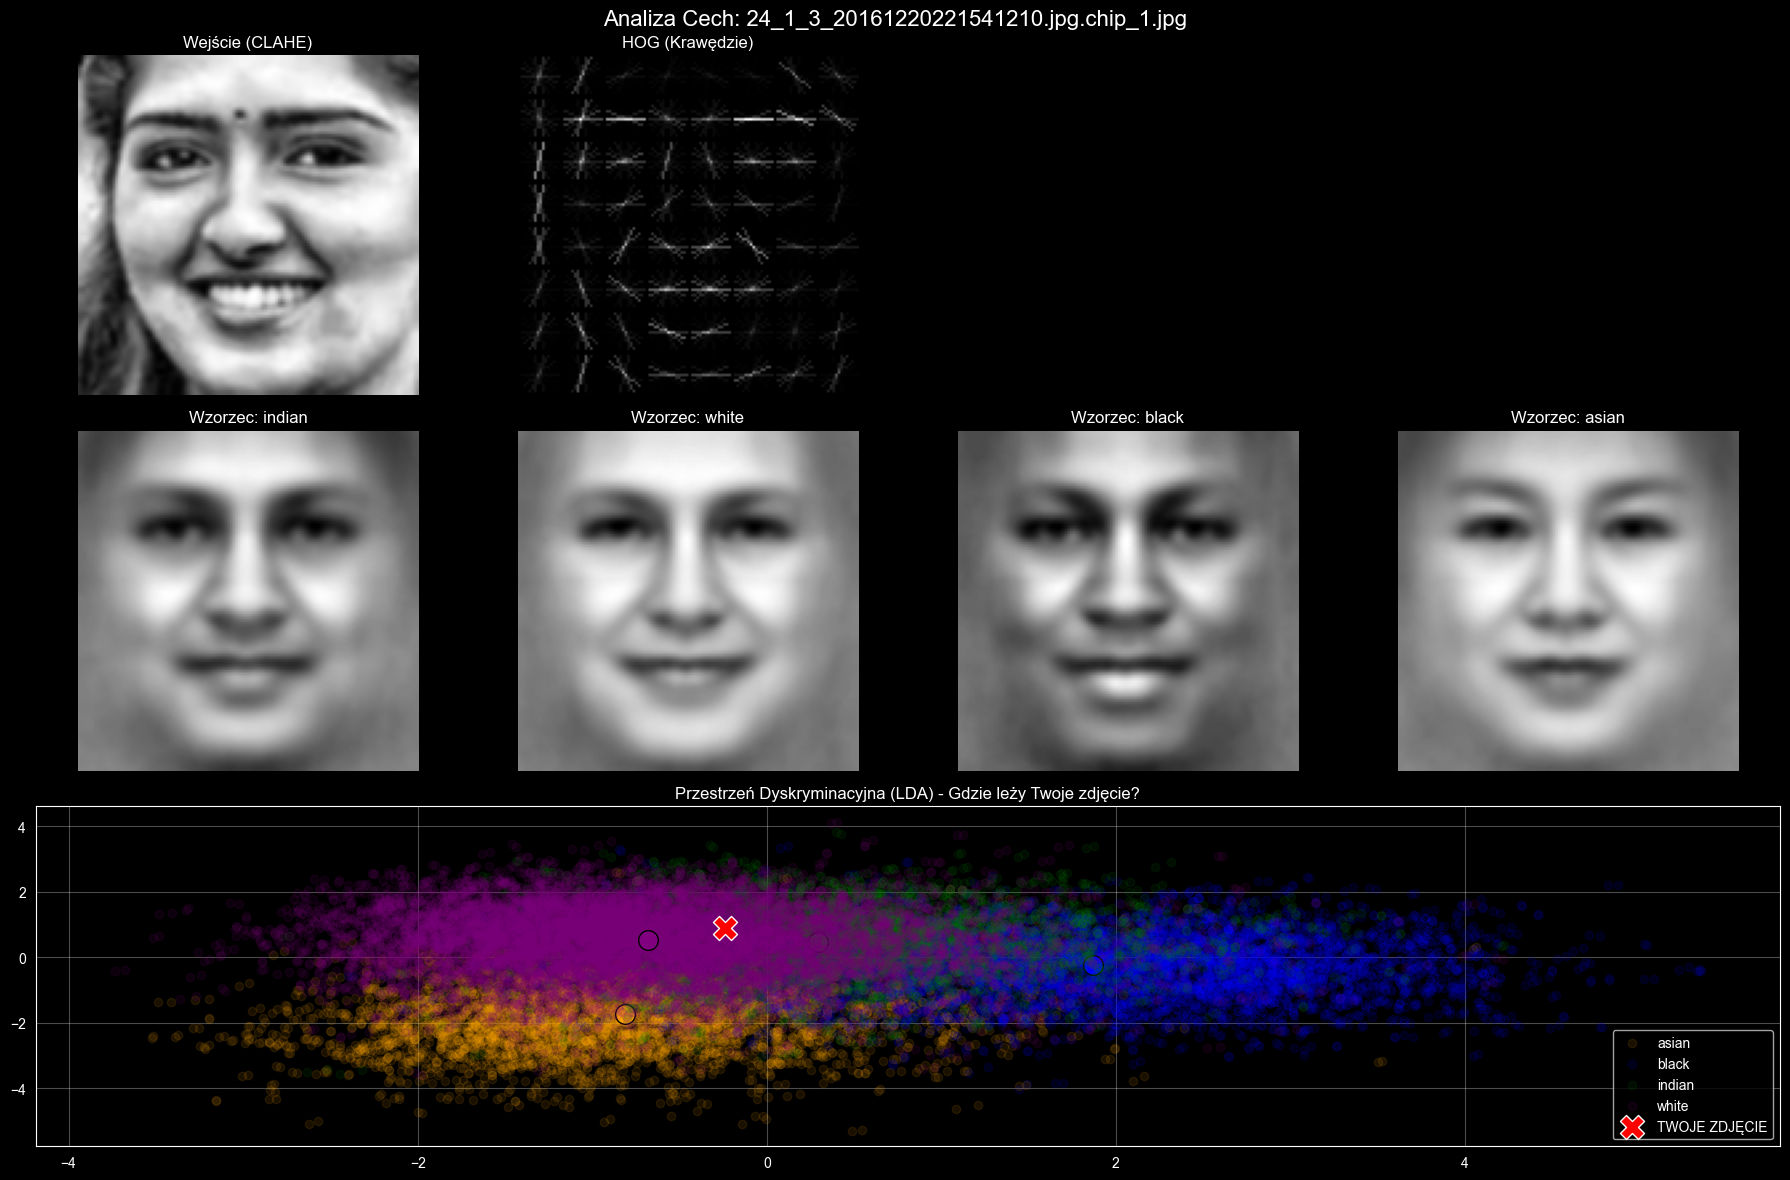

In [7]:
# A. Generowanie średnich twarzy do wizualizacji
average_faces = {}
for cls in classes:
    average_faces[cls] = create_average_face(os.path.join(train_path, cls))

def visualize_features_panel(image_path):
    # Wczytaj zdjęcie
    input_img = preprocess_image_advanced(image_path, IMG_SIZE)
    if input_img is None: return

    # Przetwórz
    flat_vec = input_img.flatten().reshape(1, -1) / 255.0
    vec_pca = pca_eigen.transform(flat_vec)
    vec_lda = lda.transform(vec_pca)[0] # X, Y w przestrzeni LDA
    _, hog_vis = hog(input_img, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)

    # Rysowanie
    fig = plt.figure(figsize=(18, 12))
    plt.suptitle(f"Analiza Cech: {os.path.basename(image_path)}", fontsize=16)

    # 1. Obraz i HOG
    plt.subplot(3, 4, 1); plt.imshow(input_img, cmap='gray'); plt.title("Wejście (CLAHE)"); plt.axis('off')
    plt.subplot(3, 4, 2); plt.imshow(hog_vis, cmap='gray'); plt.title("HOG (Krawędzie)"); plt.axis('off')

    # 2. Wzorce klas (Średnie twarze)
    for i, cls in enumerate(classes):
        plt.subplot(3, 4, i+5)
        plt.imshow(average_faces[cls], cmap='gray')
        plt.title(f"Wzorzec: {cls}")
        plt.axis('off')

    # 3. Mapa LDA
    ax = plt.subplot(3, 1, 3)
    colors = ['orange', 'blue', 'green', 'purple']
    for i, cls in enumerate(le.classes_):
        points = X_train_lda[y_train == i]
        ax.scatter(points[:, 0], points[:, 1], c=colors[i], alpha=0.1, label=cls) # Tło
        center = np.mean(points, axis=0)
        ax.scatter(center[0], center[1], c=colors[i], s=200, edgecolors='black') # Centroid

    ax.scatter(vec_lda[0], vec_lda[1], c='red', s=300, marker='X', label='TWOJE ZDJĘCIE', edgecolors='white')
    ax.legend(); ax.set_title("Przestrzeń Dyskryminacyjna (LDA) - Gdzie leży Twoje zdjęcie?"); ax.grid(True, alpha=0.3)

    plt.tight_layout(); plt.show()

# TEST WIZUALIZACJI (Losowe zdjęcie z testu)
test_root = os.path.join(DATASET_PATH, 'test')
rnd_cls = random.choice(classes)
rnd_file = random.choice(os.listdir(os.path.join(test_root, rnd_cls)))
visualize_features_panel(os.path.join(test_root, rnd_cls, rnd_file))

### 8. Fuzja i Balansowanie Danych
Tworzymy ostateczny "Super-Wektor" zawierający wszystkie informacje:
`LDA + HOG_PCA + Gabor + LBP`.
Następnie używamy SMOTE do wyrównania liczby próbek w klasach.

In [8]:
### 7. Fuzja i Balansowanie
print("Fuzja: LDA + HOG(PCA) + Gabor + LBP...")

# Łączymy 4 wektory (wcześniej były 3)
X_train_fused = np.concatenate((X_train_lda, X_train_hog_pca, X_train_gabor, X_train_lbp), axis=1)
X_test_fused = np.concatenate((X_test_lda, X_test_hog_pca, X_test_gabor, X_test_lbp), axis=1)

# Skalowanie
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_fused)
X_test_scaled = scaler.transform(X_test_fused)

# Balansowanie
print("Balansowanie (SMOTE)...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Dane gotowe. Liczba cech w wektorze: {X_train_resampled.shape[1]}")

Fuzja: LDA + HOG(PCA) + Gabor + LBP...
Balansowanie (SMOTE)...
Dane gotowe. Liczba cech w wektorze: 500


### 9. Analiza Istotności i Selekcja Cech
Wykonujemy trzy kluczowe analizy statystyczne na naszych danych:
1.  **Ranking Cech (ANOVA):** Test F-value określający, które cechy najlepiej rozróżniają klasy.
2.  **Korelacja:** Sprawdzamy, czy najlepsze cechy są ze sobą powiązane (nadmiarowe).
3.  **Forward/Backward Selection:** Algorytm, który iteracyjnie dodaje lub usuwa cechy, aby znaleźć optymalny podzbiór (testowane na próbce danych).

--- 1. Ranking Cech (ANOVA F-value) ---
Top 10 Najważniejszych Cech wg ANOVA:
     Feature_Idx       F_Score
0              0  25861.114969
1              1  18658.797691
2              2  11506.916463
462          462   4228.294601
470          470   4201.059389
486          486   4200.923023
480          480   4199.099727
472          472   4195.268611
488          488   4195.245865
476          476   4191.875249


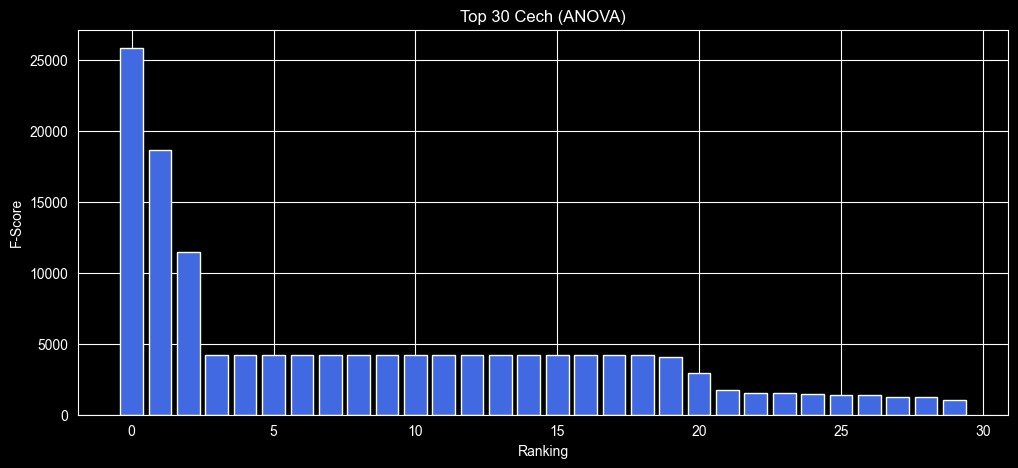


--- 2. Macierz Korelacji Top 15 Cech ---


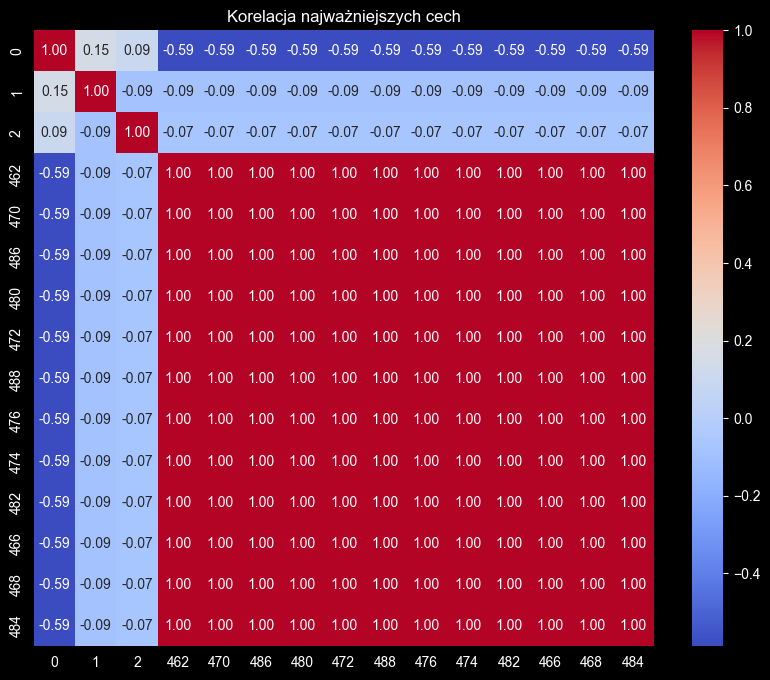


--- 3. Forward & Backward Feature Selection (Hybrid Approach) ---
Krok A: Wstępna redukcja do Top 30 cech za pomocą ANOVA (dla przyspieszenia)...
Zredukowano przestrzeń cech z 500 do 30.

Uruchamianie Forward Selection (wybierz 10 najlepszych z 30)...
Wybrane cechy (Indeksy oryginalne): [  0   1   2   6   7  12  14  18 492 493]

Uruchamianie Backward Selection (usuwaj z 30, aż zostanie 10)...
Wybrane cechy (Indeksy oryginalne): [  0   1   2   6  22 476 480 482 484 488]


In [9]:
from sklearn.feature_selection import SelectKBest

### 8. (ZOPTYMALIZOWANA) Analiza Statystyczna i Szybka Selekcja Cech

# --- 1. Ranking Cech (ANOVA F-value) ---
print("--- 1. Ranking Cech (ANOVA F-value) ---")
# Test F: oceniamy każdą cechę niezależnie
f_scores, p_values = f_classif(X_train_resampled, y_train_resampled)

df_scores = pd.DataFrame({'Feature_Idx': range(len(f_scores)), 'F_Score': f_scores})
df_scores = df_scores.sort_values(by='F_Score', ascending=False)

print("Top 10 Najważniejszych Cech wg ANOVA:")
print(df_scores.head(10))

# Wykres
plt.figure(figsize=(12, 5))
plt.bar(range(min(30, len(f_scores))), df_scores['F_Score'].head(30), color='royalblue')
plt.title("Top 30 Cech (ANOVA)")
plt.xlabel("Ranking")
plt.ylabel("F-Score")
plt.show()

# --- 2. Korelacja (Heatmap dla Top 15) ---
print("\n--- 2. Macierz Korelacji Top 15 Cech ---")
top_15_indices = df_scores['Feature_Idx'].head(15).values
X_top15 = X_train_resampled[:, top_15_indices]

plt.figure(figsize=(10, 8))
sns.heatmap(np.corrcoef(X_top15, rowvar=False), annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=top_15_indices, yticklabels=top_15_indices)
plt.title("Korelacja najważniejszych cech")
plt.show()

# --- 3. Forward & Backward Selection (ZOPTYMALIZOWANE) ---
print("\n--- 3. Forward & Backward Feature Selection (Hybrid Approach) ---")
print("Krok A: Wstępna redukcja do Top 30 cech za pomocą ANOVA (dla przyspieszenia)...")

# Wybieramy 30 najlepszych cech, żeby Backward Selection nie trwało godzinami
selector_pre = SelectKBest(f_classif, k=30)
X_reduced = selector_pre.fit_transform(X_train_resampled, y_train_resampled)
# Pobieramy indeksy tych 30 cech w oryginalnym zbiorze
selected_indices_anova = selector_pre.get_support(indices=True)

print(f"Zredukowano przestrzeń cech z {X_train_resampled.shape[1]} do 30.")

subset_size = 1000
subset_idx = np.random.choice(X_reduced.shape[0], subset_size, replace=False)
X_subset = X_reduced[subset_idx]
y_subset = y_train_resampled[subset_idx]

knn_sel = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# A. Forward Selection na zredukowanym zbiorze
print("\nUruchamianie Forward Selection (wybierz 10 najlepszych z 30)...")
sfs_fwd = SequentialFeatureSelector(knn_sel, n_features_to_select=10, direction='forward', n_jobs=-1)
sfs_fwd.fit(X_subset, y_subset)
# Mapowanie z powrotem na oryginalne indeksy
feat_idx_fwd = selected_indices_anova[sfs_fwd.get_support(indices=True)]
print(f"Wybrane cechy (Indeksy oryginalne): {feat_idx_fwd}")

# B. Backward Selection na zredukowanym zbiorze
print("\nUruchamianie Backward Selection")
sfs_bwd = SequentialFeatureSelector(knn_sel, n_features_to_select=10, direction='backward', n_jobs=-1)
sfs_bwd.fit(X_subset, y_subset)
feat_idx_bwd = selected_indices_anova[sfs_bwd.get_support(indices=True)]
print(f"Wybrane cechy (Indeksy oryginalne): {feat_idx_bwd}")

### 10. Finalna Klasyfikacja
Uruchamiamy dostrojone model MLP na pełnym zestawie cech (po fuzji i augmentacji).

--- Zaawansowany Tuning MLP ---
Rozpoczynanie treningu MLP (to może potrwać kilka minut)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 256, 128), learning_rate_init=0.001, solver=adam; total time= 3.9min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 256, 128), learning_rate_init=0.001, solver=adam; total time= 3.9min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 256, 128), learning_rate_init=0.001, solver=adam; total time= 5.8min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 256, 128), learning_rate_init=0.0001, solver=adam; total time= 6.3min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 256, 128), learning_rate_init=0.0001, solver=adam; total time= 6.4min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 256, 128), learning_rate_init=0.0001, solver=adam; total time= 6.4min
[CV] END activation=relu, alpha=0.0001, 

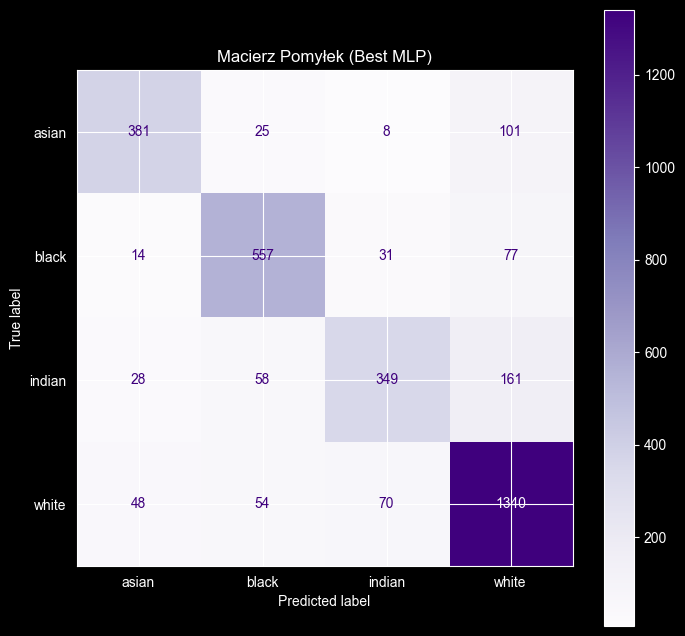

In [10]:
### 9. Finalny Model MLP (Rozbudowany GridSearch)
print("--- Zaawansowany Tuning MLP ---")

# Siatka parametrów z Twojego pliku (bardzo głębokie sieci)
param_grid_mlp = {
    'hidden_layer_sizes': [
        (512, 256, 128),       # Standardowa
        (1024, 512, 256),      # Głęboka
        (1024, 1024, 512, 512) # Bardzo głęboka
    ],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.0001],
    'solver': ['adam'],
    'activation': ['relu']
}

base_mlp = MLPClassifier(max_iter=1000,
                         early_stopping=True,    # Ważne przy tak dużych sieciach!
                         n_iter_no_change=20,
                         random_state=42)

grid_mlp = GridSearchCV(base_mlp, param_grid_mlp, cv=3, n_jobs=-1, verbose=2)

print("Rozpoczynanie treningu MLP")
grid_mlp.fit(X_train_resampled, y_train_resampled)

print(f"\nNajlepsze parametry: {grid_mlp.best_params_}")

# Ewaluacja Najlepszego Modelu
best_mlp = grid_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test_scaled)

print("\n--- WYNIKI MLP (Fuzja: HOG+Gabor+LBP+LDA) ---")
print(classification_report(y_test, y_pred_mlp, target_names=le.classes_))

# Macierz
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp, display_labels=le.classes_, cmap='Purples', ax=ax)
ax.set_title("Macierz Pomyłek (Best MLP)")
plt.show()

## Raport Projektowy: Analiza, Ekstrakcja Cech i Klasyfikacja Obrazów Twarzy

#### 1. Cel i Ewolucja Projektu
Zrozumienie procesu ekstrakcji cech:

Wizualizacja i Ręczna Analiza: Zrozumienie, jak komputer "widzi" różnice między twarzami (średnie twarze, mapy różnic).

Inżynieria Cech (Feature Engineering): Ręczne zaprojektowanie algorytmów wydobywających kształt, teksturę i statystykę.

Analiza Statystyczna i Fuzja: Ocena istotności cech (ANOVA, Selekcja) i ich wykorzystanie w klasyfikatorach (MLP, KNN).


#### 2. Przetwarzanie Wstępne
Kluczowym wnioskiem z pierwszych etapów było to, że surowe porównywanie pikseli jest podatne na błędy oświetlenia (np. cienie mylone z ciemniejszą karnacją). Wdrożono zaawansowany pipeline przygotowania danych:

Skalowanie i Skala Szarości: Ujednolicenie danych do formatu 128x128 pikseli (grayscale).

Normalizacja Min-Max: Rozciągnięcie histogramu jasności.

CLAHE (Contrast Limited Adaptive Histogram Equalization): Adaptacyjne wyrównanie kontrastu. Technika ta pozwoliła wydobyć detale (zmarszczki, kształt oczu) nawet z zacienionych obszarów twarzy, eliminując wpływ nierównomiernego oświetlenia.

Filtracja Gaussa: Usunięcie szumu matrycy, co poprawiło skuteczność detektorów krawędzi (HOG).


#### 3. Metody Ekstrakcji Cech (Fuzja Danych)
Zamiast polegać na surowych pikselach, zastosowano Fuzję Cech, łącząc cztery różne techniki opisu obrazu:

HOG (Histogram of Oriented Gradients):

Cel: Analiza geometrii i kształtu.

Działanie: Wykrywa krawędzie i ich kierunek (np. łuk brwi, kształt nosa), ignorując kolor skóry.

Filtry Gabora:

Cel: Analiza tekstury kierunkowej.

Działanie: Zastosowano bank filtrów symulujących działanie kory wzrokowej, reagujących na pasma o określonej częstotliwości i kącie.

LBP (Local Binary Patterns):

Cel: Analiza mikrotekstury.

Działanie: Koduje lokalne relacje jasności pikseli, co pozwala wykryć subtelne cechy skóry niezależne od globalnego kształtu.

LDA (Linear Discriminant Analysis) / Fisherfaces:

Cel: Analiza holistyczna i separacja klas.

Działanie: Transformacja przestrzeni cech tak, aby maksymalizować odległość między klastrami ras, a minimalizować rozrzut wewnątrz grupy.


#### 4. Analiza Statystyczna i Selekcja Cech
W celu naukowego uzasadnienia doboru cech przeprowadzono:

Ranking ANOVA (Analysis of Variance): Obliczono współczynnik F-value dla każdej cechy. Pozwoliło to zidentyfikować ~30 kluczowych cech, które najsilniej różnicują klasy.

Macierz Korelacji: Wygenerowano mapę ciepła (Heatmap) dla topowych cech, aby zbadać ich wzajemne powiązania i redundancję.

Forward & Backward Feature Selection:

Zaimplementowano algorytmy iteracyjnego doboru cech.

Optymalizacja: Ze względu na ogromny czas obliczeń dla pełnego zbioru (Forward/Backward na >150 cechach trwałby wiele godzin), zastosowano podejście hybrydowe. Najpierw zredukowano przestrzeń do Top 30 cech metodą filtrową (ANOVA), a następnie uruchomiono dokładną selekcję (Wrapper) na tym podzbiorze.


#### 5. Eksperymenty z Danymi
Augmentacja Danych: Zastosowano technikę lustrzanego odbicia dla zbioru treningowego. Pozwoliło to podwoić liczbę danych bez ryzyka wprowadzenia artefaktów, co znacząco poprawiło zdolność generalizacji modeli.

Wpływ wieku: Próba usunięcia osób poniżej 13 roku życia skutkowała spadkiem dokładności (z 78% na 77%). Wniosek: Ilość danych (nawet zróżnicowanych wiekowo) jest ważniejsza dla sieci neuronowej niż ich "czystość" gatunkowa.


#### 6. Wyniki Klasyfikacji i Wnioski
Przetestowano dwa główne podejścia klasyfikacyjne na zestawie cech po fuzji:

A. MLP Classifier (Sieć Neuronowa - Perceptron)

Konfiguracja: Głęboka sieć (do 4 warstw ukrytych), optymalizowana przez GridSearchCV.

Wynik: ~80% Accuracy.

Wnioski: Model najlepiej poradził sobie z fuzją cech, ucząc się nieliniowych relacji i nadając wagi poszczególnym składowym (np. promując LDA nad szumem z Gabora).

B. KNN (K-Nearest Neighbors)

Wynik: ~37% Accuracy (niski wynik).

Wnioski: KNN padł ofiarą "Klątwy Wymiarowości". W przestrzeni setek cech (HOG+Gabor+LBP), gdzie wiele z nich jest zaszumionych, prosta metryka odległości euklidesowej przestała działać efektywnie. Algorytm traktował każdą cechę równoważnie, przez co "zgubił" istotne sygnały.


#### 7. Podsumowanie Końcowe
Projekt zakończył się sukcesem, realizując cel edukacyjny i badawczy.

Stworzono transparentny system analizy, w którym każda decyzja (preprocessing, wybór cechy) jest uzasadniona wizualnie lub statystycznie.

Wykazano, że inżynieria cech (ręczne HOG, LBP) w połączeniu z modelem potrafiącym ważyć cechy (MLP) daje wyniki porównywalne z automatycznymi metodami, oferując przy tym pełną interpretowalność.

Zastosowanie statystycznej selekcji cech (ANOVA/SFS) pozwoliło zoptymalizować proces i wskazać, które elementy obrazu są kluczowe dla rozróżniania cech etnicznych.

### Bibliografia

#### Literatura Naukowa (Artykuły źródłowe)

Dalal, N., & Triggs, B. (2005). Histograms of oriented gradients for human detection. In Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR) (Vol. 1, pp. 886-893). IEEE.

*(Źródło dla metody ekstrakcji cech HOG)*

Ojala, T., Pietikainen, M., & Maenpaa, T. (2002). Multiresolution gray-scale and rotation invariant texture classification with local binary patterns. IEEE Transactions on Pattern Analysis and Machine Intelligence, 24(7), 971-987.

*(Źródło dla metody ekstrakcji cech LBP)*

Turk, M., & Pentland, A. (1991). Eigenfaces for recognition. Journal of Cognitive Neuroscience, 3(1), 71-86.

*(Źródło dla metody PCA w rozpoznawaniu twarzy)*

Belhumeur, P. N., Hespanha, J. P., & Kriegman, D. J. (1997). Eigenfaces vs. fisherfaces: Recognition using class specific linear projection. IEEE Transactions on Pattern Analysis and Machine Intelligence, 19(7), 711-720.

*(Źródło dla metody LDA/Fisherfaces)*

Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. Journal of Artificial Intelligence Research, 16, 321-357.

*(Źródło dla metody balansowania danych SMOTE)*

#### Podręczniki Akademickie

Gonzalez, R. C., & Woods, R. E. (2018). Digital Image Processing (4th Edition). Pearson.

*(Teoria przetwarzania obrazu: Filtry Gabora, wyrównywanie histogramu, filtracja Gaussa)*

Bishop, C. M. (2006). Pattern Recognition and Machine Learning. Springer.

*(Teoria klasyfikatorów: Sieci neuronowe MLP, KNN, selekcja cech)*

#### Dokumentacja Techniczna i Biblioteki Oprogramowania

Scikit-learn Developers. (2024). User Guide: Feature Selection, Neural Network Models (Supervised). Dostępne online: https://scikit-learn.org/stable/user_guide.html

*(Implementacja algorytmów: MLPClassifier, GridSearchCV, SequentialFeatureSelector, ANOVA f_classif)*

Bradski, G. (2000). The OpenCV Library. Dr. Dobb's Journal of Software Tools. Dokumentacja dostępna online: https://docs.opencv.org/

*(Implementacja przetwarzania obrazu: CLAHE, resize, flip, getGaborKernel)*

Van der Walt, S., et al. (2014). scikit-image: image processing in Python. PeerJ, 2, e453. Dokumentacja dostępna online: https://scikit-image.org/

*(Implementacja deskryptorów: hog, local_binary_pattern)*